In [1]:
import numpy as np
import os
import pandas as pd

In [2]:
'''''CriticNet'''  
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.stats import norm  
  
from keras.layers import Input, Dense, Lambda  
from keras.models import Model  
from keras import backend as K  
from keras import objectives  
from keras.datasets import mnist  
from keras.utils.vis_utils import plot_model  
import sys

batch_size = 100  
original_dim = 256   
latent_dim = 1
intermediate_dim = 128  #AE is 128
nb_epoch = 50  
epsilon_std = 1.0  
 
#encoding  
x = Input(shape=(original_dim,))  
h = Dense(intermediate_dim, activation='relu')(x)  
z_mean = Dense(latent_dim)(h)  
z_log_var = Dense(latent_dim)(h)  



#Gauss sampling,sample Z  
def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon



z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

 
decoder_h = Dense(intermediate_dim, activation='relu')(z) 
decoder_mean = Dense(original_dim, activation='sigmoid')(decoder_h)




def vae_loss(x, decoder_mean):  
    xent_loss = original_dim * objectives.binary_crossentropy(x,decoder_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  
    constrain_loss = -K.sum(K.square(decoder_mean-0.5))
    return xent_loss + 1*kl_loss  + 0*constrain_loss

vae = Model(x, decoder_mean) 
vae.compile(optimizer='rmsprop', loss=vae_loss)  

newdata = pd.read_csv("ISING_simul/IsingModel16_16simul.csv").values
for i in range(len(newdata)):
    for j in range(len(newdata[0])):
        newdata[i][j] = (newdata[i][j]+1)/2
index = [i for i in range(len(newdata))]
import random
random.shuffle(index)
newdata = newdata[index]
x_train = newdata[:15000]
x_test = newdata[15000:20000]


Using TensorFlow backend.


In [3]:
vae.fit(x_train, x_train,  
        shuffle=True,  
        nb_epoch=nb_epoch,  
        #verbose=2,  
        batch_size=100,  
        validation_data=(x_test, x_test))  

/Users/sunhop/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 15000 samples, validate on 5000 samples
Epoch 1/50
15000/15000 [==============================] - 1s - loss: 141.5627 - val_loss: 122.6074
Epoch 2/50
15000/15000 [==============================] - 0s - loss: 119.4653 - val_loss: 117.6158
Epoch 3/50
15000/15000 [==============================] - 0s - loss: 117.2666 - val_loss: 118.3597
Epoch 4/50
15000/15000 [==============================] - 0s - loss: 116.3179 - val_loss: 115.5339
Epoch 5/50
15000/15000 [==============================] - 0s - loss: 115.8667 - val_loss: 114.8555
Epoch 6/50
15000/15000 [==============================] - 0s - loss: 115.1613 - val_loss: 114.5154
Epoch 7/50
15000/15000 [==============================] - 0s - loss: 114.9296 - val_loss: 114.0135
Epoch 8/50
15000/15000 [==============================] - 0s - loss: 114.5671 - val_loss: 113.8033
Epoch 9/50
15000/15000 [==============================] - 0s - loss: 114.1177 - val_loss: 115.3282
Epoch 10/50
15000/15000 [==============================] - 0

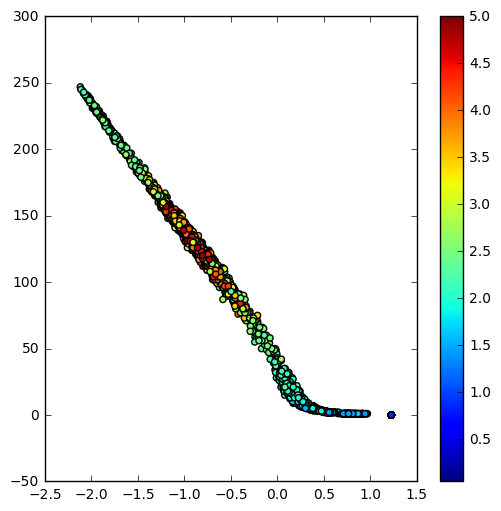

"this figure shows the Critic's ability of finding intrinsic law"

In [5]:
T = np.zeros((20099,))
u=5.025
for i in range(20099):
    
    if i%101==0:
        u = u- 0.025
    T[i]=u
T = T[index]

T_train = T[:15000]
T_test = T[15000:20000]
y_test = np.zeros((len(x_test),))
for i in range(len(x_test)):
    y_test[i]= np.sum(x_test[i])

encoder = Model(x, z_mean)
  
# display a 2D plot of the digit classes in the latent space  
x_test_encoded_1 = encoder.predict(x_test, batch_size=batch_size)  
plt.figure(figsize=(6, 6))  
plt.scatter( (x_test_encoded_1[:, 0]) ,y_test , c=T_test)  
plt.colorbar()  
plt.show()  
  
'''this figure shows the Critic's ability of finding intrinsic law'''

In [6]:
Magnet_trained= Model(x, z_mean)

In [7]:
import tensorflow as tf
W_0 = tf.convert_to_tensor(Magnet_trained.layers[1].get_weights()[0])
b_0 = tf.convert_to_tensor(Magnet_trained.layers[1].get_weights()[1])
W_1 = tf.convert_to_tensor(Magnet_trained.layers[2].get_weights()[0])
b_1 = tf.convert_to_tensor(Magnet_trained.layers[2].get_weights()[1])

In [878]:
'''ActorNet'''
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.stats import norm  
from keras.constraints import maxnorm,unit_norm,unitnorm
from keras.layers import Input, Dense, Lambda,concatenate
from keras.models import Model  
from keras import regularizers
from keras import backend as K  
from keras import objectives  
from keras.datasets import mnist  
from keras.utils.vis_utils import plot_model  
import sys

batch_size = 100  
original_dim = 256   
latent_dim = 1
intermediate_dim = 512  #AE is 128
nb_epoch = 50
epsilon_std = 1.0
 
#encoding  
x = Input(shape=(original_dim,))

#Merged_1 = concatenate([x,x,x,x])
h = Dense(128, activation='sigmoid')(x)
decoded = Dense(original_dim, activation='sigmoid')(x)

def calc_mm(x):
    return K.bias_add(K.dot(K.bias_add(K.dot(x,W_0),b_0),W_1),b_1)

def vae_loss(x, decoded):
    binary_loss= original_dim * objectives.binary_crossentropy(x,decoded)
    xent_loss =K.sum(K.square(calc_mm(x)-calc_mm(decoded)))
    #xent_loss =K.sum(K.square(K.sum(x,axis=-1)-K.sum(decoded,axis=-1)))
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  
    constrain_loss = -K.sum(K.square(decoded-0.5))
    return xent_loss + 0.5*constrain_loss



#def vae_loss(x, decoder_mean):  
#    xent_loss = original_dim * objectives.binary_crossentropy(x,decoder_mean)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  
#    constrain_loss = -K.sum(K.square(decoder_mean-0.5))
#    return xent_loss + 1*kl_loss  + 0*constrain_loss

Actor= Model(x, decoded) 
import keras
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
Actor.compile(optimizer='rmsprop', loss=vae_loss)  

newdata = pd.read_csv("ISING_simul/IsingModel16_16simul.csv").values
for i in range(len(newdata)):
    for j in range(len(newdata[0])):
        newdata[i][j] = (newdata[i][j]+1)/2
index = [i for i in range(len(newdata))]
import random
random.shuffle(index)
newdata = newdata[index]
x_train = newdata[:15000]
x_test = newdata[15000:20000]

In [879]:
Actor.fit(x_train, x_train,  
        shuffle=True,  
        nb_epoch=30,  
        #verbose=2,  
        batch_size=100,  
        validation_data=(x_test, x_test),callbacks=[EarlyStopping])  

/Users/sunhop/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 15000 samples, validate on 5000 samples
Epoch 1/30
15000/15000 [==============================] - 1s - loss: 173238.5452 - val_loss: 161619.4758
Epoch 2/30
15000/15000 [==============================] - 0s - loss: 143411.1845 - val_loss: 135231.2170
Epoch 3/30
15000/15000 [==============================] - 0s - loss: 119295.6720 - val_loss: 112201.8747
Epoch 4/30
15000/15000 [==============================] - 0s - loss: 98824.6581 - val_loss: 92859.2681
Epoch 5/30
15000/15000 [==============================] - 0s - loss: 81144.7051 - val_loss: 75703.4784
Epoch 6/30
15000/15000 [==============================] - 0s - loss: 65998.3682 - val_loss: 61314.8755
Epoch 7/30
15000/15000 [==============================] - 0s - loss: 53238.9985 - val_loss: 49226.1982
Epoch 8/30
15000/15000 [==============================] - 0s - loss: 42476.8719 - val_loss: 39039.9217
Epoch 9/30
15000/15000 [==============================] - 0s - loss: 33529.1477 - val_loss: 30741.2570
Epoch 10/30
15000/

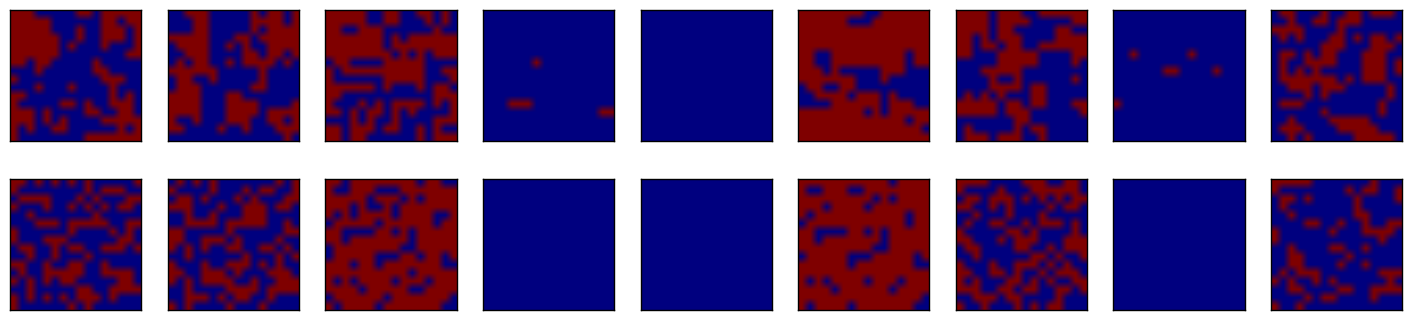

In [880]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)
decoded_imgs = Actor.predict(x_test,batch_size=100)


n = 10  # how many digits we will display
N = 10
plt.figure(figsize=(20, 4))
for i in range(N-n+1,N):
    # display original
    ax = plt.subplot(2,n,i-N+n)
    plt.imshow(np.round(x_test[i].reshape(16, 16)))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2,n,i+n-N+n)
    plt.imshow(np.round(decoded_imgs[i].reshape(16,16)))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [881]:
'''TEST from statistics' perspective'''

"TEST from statistics' perspective"

In [882]:
generated = Actor.predict(newdata)
generated = np.round(generated)


AAA = np.mean(generated,axis=0)
BBB = np.mean(newdata,axis=0)
print(np.mean(generated))
print(np.std(generated))
print(np.mean(newdata))
print(np.std(newdata))

0.306958
0.461232
0.293813591472
0.455507590429


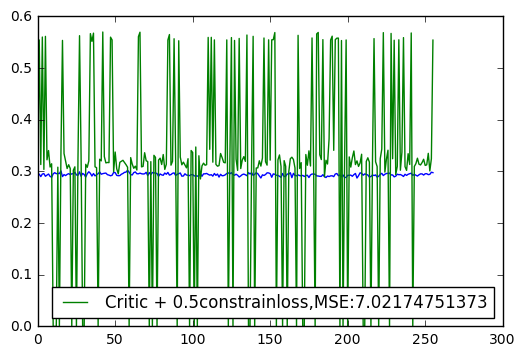

In [940]:
import matplotlib.pyplot as plt
plt.plot(BBB)
plt.plot(C_2,label = 'Critic + 0.5constrainloss,MSE:'+str(np.sum(np.square(C_2-BBB))))
plt.legend(loc='lower right')
plt.show()

In [884]:
AAA[AAA>0.4].shape[0]+AAA[AAA<0.2].shape[0]

90

In [847]:
C_7 = AAA

In [854]:
C_8 = AAA

In [861]:
C_9 = AAA

In [885]:
C_10 = AAA

In [840]:
C_6 = AAA

In [833]:
C_5 = AAA

In [826]:
C_4 = AAA

In [803]:
C_1 = AAA

In [812]:
C_2 = AAA

In [819]:
C_3 = AAA

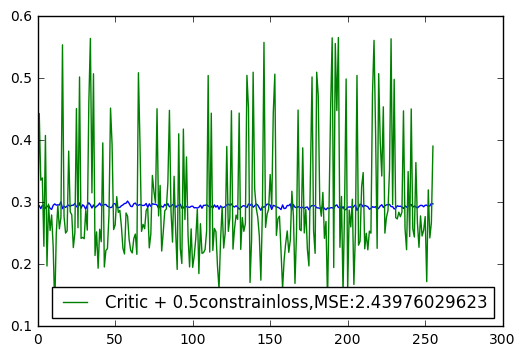

In [932]:
import matplotlib.pyplot as plt
plt.plot(BBB)
plt.plot(np.mean([C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10],axis = 0),label = 'Critic + 0.5constrainloss,MSE:'+str(np.sum(np.square(np.mean([C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10],axis = 0)-BBB))))
plt.legend(loc='lower right')
plt.show()

In [920]:
'''ActorNet'''
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.stats import norm  
from keras.constraints import maxnorm,unit_norm,unitnorm
from keras.layers import Input, Dense, Lambda,concatenate
from keras.models import Model  
from keras import regularizers
from keras import backend as K  
from keras import objectives  
from keras.datasets import mnist  
from keras.utils.vis_utils import plot_model  
import sys

batch_size = 100  
original_dim = 256   
latent_dim = 1
intermediate_dim = 512  #AE is 128
nb_epoch = 50
epsilon_std = 1.0
scale_aug = 4
 
#encoding  
x = Input(shape=(original_dim,))

decoded = Dense(original_dim*scale_aug, activation='sigmoid')(x)

def calc_mm(x):
    return K.bias_add(K.dot(K.bias_add(K.dot(x,W_0),b_0),W_1),b_1)

def vae_loss(x, decoded):
    MM_decoded = 0
    for i in range(scale_aug):
        MM_decoded += calc_mm(decoded[:,i*original_dim:(i+1)*original_dim])/scale_aug 
    binary_loss= original_dim * objectives.binary_crossentropy(x,decoded)
    xent_loss =K.sum(K.square(calc_mm(x)-MM_decoded))
    #xent_loss =K.sum(K.square(K.sum(x,axis=-1)-K.sum(decoded,axis=-1)))
    constrain_loss = -K.sum(K.square(decoded-0.5))
    return xent_loss + 0.5*constrain_loss


Actor= Model(x, decoded) 
import keras
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
Actor.compile(optimizer='rmsprop', loss=vae_loss)  

newdata = pd.read_csv("ISING_simul/IsingModel16_16simul.csv").values
for i in range(len(newdata)):
    for j in range(len(newdata[0])):
        newdata[i][j] = (newdata[i][j]+1)/2
index = [i for i in range(len(newdata))]
import random
random.shuffle(index)
newdata = newdata[index]
x_train = newdata[:15000]
x_test = newdata[15000:20000]

In [921]:
Actor.fit(x_train, x_train,  
        shuffle=True,  
        nb_epoch=30,  
        #verbose=2,  
        batch_size=100,  
        validation_data=(x_test, x_test),callbacks=[EarlyStopping])  

/Users/sunhop/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 15000 samples, validate on 5000 samples
Epoch 1/30
15000/15000 [==============================] - 2s - loss: 174532.9914 - val_loss: 158078.1028
Epoch 2/30
15000/15000 [==============================] - 1s - loss: 143616.8753 - val_loss: 130874.8587
Epoch 3/30
15000/15000 [==============================] - 0s - loss: 119061.2330 - val_loss: 108464.7203
Epoch 4/30
15000/15000 [==============================] - 1s - loss: 98000.3772 - val_loss: 89104.1020
Epoch 5/30
15000/15000 [==============================] - 0s - loss: 79982.7366 - val_loss: 72378.9686
Epoch 6/30
15000/15000 [==============================] - 0s - loss: 64441.5905 - val_loss: 58241.3983
Epoch 7/30
15000/15000 [==============================] - 0s - loss: 51269.9399 - val_loss: 46342.7041
Epoch 8/30
15000/15000 [==============================] - 0s - loss: 40242.5136 - val_loss: 36091.6715
Epoch 9/30
15000/15000 [==============================] - 1s - loss: 30985.0893 - val_loss: 27170.6124
Epoch 10/30
15000/

/Users/sunhop/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


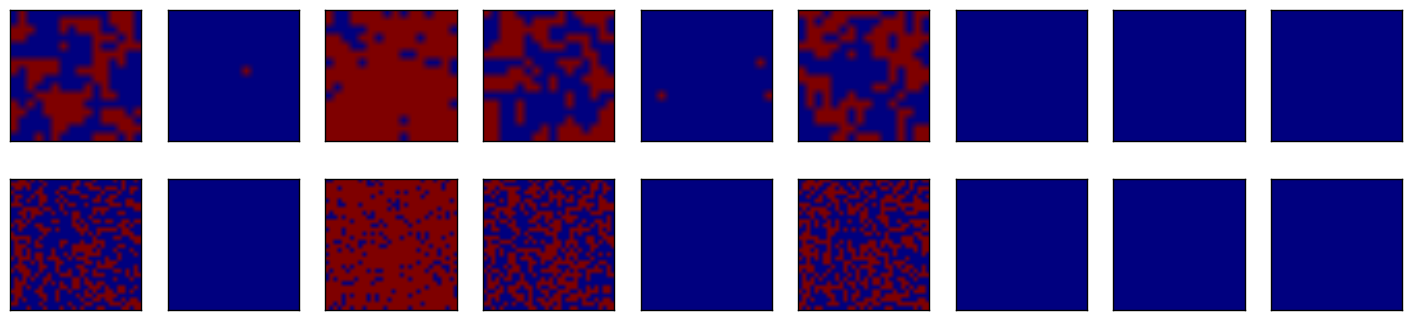

In [922]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)
decoded_imgs = Actor.predict(x_test,batch_size=100)


n = 10  # how many digits we will display
N = 10
plt.figure(figsize=(20, 4))
for i in range(N-n+1,N):
    # display original
    ax = plt.subplot(2,n,i-N+n)
    plt.imshow(np.round(x_test[i].reshape(16, 16)))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2,n,i+n-N+n)
    plt.imshow(np.round(decoded_imgs[i].reshape(16*np.sqrt(scale_aug),16*np.sqrt(scale_aug))))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [923]:
generated = Actor.predict(newdata)
generated = np.round(generated)


AAA = np.mean(generated,axis=0)
BBB = np.mean(newdata,axis=0)
print(np.mean(generated))
print(np.std(generated))
print(np.mean(newdata))
print(np.std(newdata))

0.299874
0.458203
0.293813591472
0.455507590429


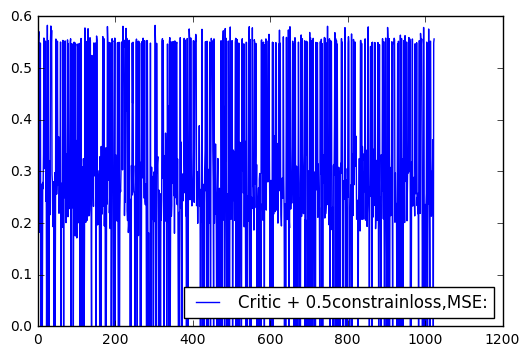

In [924]:
import matplotlib.pyplot as plt
#plt.plot(BBB)
plt.plot(AAA,label = 'Critic + 0.5constrainloss,MSE:')
plt.legend(loc='lower right')
plt.show()

In [928]:
(AAA[AAA>0.4].shape[0])/scale_aug/256

0.271484375

In [929]:
(AAA[AAA<0.2].shape[0])/scale_aug/256

0.1962890625

In [931]:
13/0.29

44.827586206896555

In [935]:
7.16/2.43

2.9465020576131686

In [942]:
(7-2.43)*3/2

6.855

In [945]:
'''ActorNet'''
CC = []
import time
time_start = time.time()
for Count in range(25):

    import numpy as np  
    import matplotlib.pyplot as plt  
    from scipy.stats import norm  
    from keras.constraints import maxnorm,unit_norm,unitnorm
    from keras.layers import Input, Dense, Lambda,concatenate
    from keras.models import Model  
    from keras import regularizers
    from keras import backend as K  
    from keras import objectives  
    from keras.datasets import mnist  
    from keras.utils.vis_utils import plot_model  
    import sys

    batch_size = 100  
    original_dim = 256   
    latent_dim = 1
    intermediate_dim = 512  #AE is 128
    nb_epoch = 50
    epsilon_std = 1.0
    scale_aug = 4

    #encoding  
    x = Input(shape=(original_dim,))

    decoded = Dense(original_dim*scale_aug, activation='sigmoid')(x)

    def calc_mm(x):
        return K.bias_add(K.dot(K.bias_add(K.dot(x,W_0),b_0),W_1),b_1)

    def vae_loss(x, decoded):
        MM_decoded = 0
        for i in range(scale_aug):
            MM_decoded += calc_mm(decoded[:,i*original_dim:(i+1)*original_dim])/scale_aug 
        binary_loss= original_dim * objectives.binary_crossentropy(x,decoded)
        xent_loss =K.sum(K.square(calc_mm(x)-MM_decoded))
        #xent_loss =K.sum(K.square(K.sum(x,axis=-1)-K.sum(decoded,axis=-1)))
        constrain_loss = -K.sum(K.square(decoded-0.5))
        return xent_loss + 0.5*constrain_loss


    Actor= Model(x, decoded) 
    import keras
    EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
    Actor.compile(optimizer='rmsprop', loss=vae_loss)  

    newdata = pd.read_csv("ISING_simul/IsingModel16_16simul.csv").values
    for i in range(len(newdata)):
        for j in range(len(newdata[0])):
            newdata[i][j] = (newdata[i][j]+1)/2
    index = [i for i in range(len(newdata))]
    import random
    random.shuffle(index)
    newdata = newdata[index]
    x_train = newdata[:15000]
    x_test = newdata[15000:20000]

    Actor.fit(x_train, x_train,  
            shuffle=True,  
            nb_epoch=30,  
            #verbose=2,  
            batch_size=100,  
            validation_data=(x_test, x_test),callbacks=[EarlyStopping])  

    generated = Actor.predict(newdata)
    generated = np.round(generated)
    AAA = np.mean(generated,axis=0)
    BBB = np.mean(newdata,axis=0)
    print(np.mean(generated))
    print(np.std(generated))
    print(np.mean(newdata))
    print(np.std(newdata))
    CC.append(AAA)
    
time_end = time.time()
print("total time for 25*20000*4 samples:",time_end-time_start)

/Users/sunhop/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 15000 samples, validate on 5000 samples
Epoch 1/30
15000/15000 [==============================] - 2s - loss: 174947.4001 - val_loss: 158768.4911
Epoch 2/30
15000/15000 [==============================] - 1s - loss: 144134.1052 - val_loss: 130762.4797
Epoch 3/30
15000/15000 [==============================] - 1s - loss: 119521.4618 - val_loss: 108351.3152
Epoch 4/30
15000/15000 [==============================] - 1s - loss: 98393.1682 - val_loss: 88824.8647
Epoch 5/30
15000/15000 [==============================] - 1s - loss: 80359.4864 - val_loss: 72113.0756
Epoch 6/30
15000/15000 [==============================] - 1s - loss: 64702.4025 - val_loss: 57886.3255
Epoch 7/30
15000/15000 [==============================] - 1s - loss: 51532.7569 - val_loss: 45664.5842
Epoch 8/30
15000/15000 [==============================] - 1s - loss: 40483.2027 - val_loss: 35524.4487
Epoch 9/30
15000/15000 [==============================] - 1s - loss: 31193.8471 - val_loss: 27020.8825
Epoch 10/30
15000/

In [946]:
CC = np.asarray(CC)

In [947]:
CC.shape

(25, 1024)

In [949]:
np.mean(CC)

0.29607534

In [958]:
CC_1 = np.mean(CC,axis=0)
CC_1.shape

(1024,)

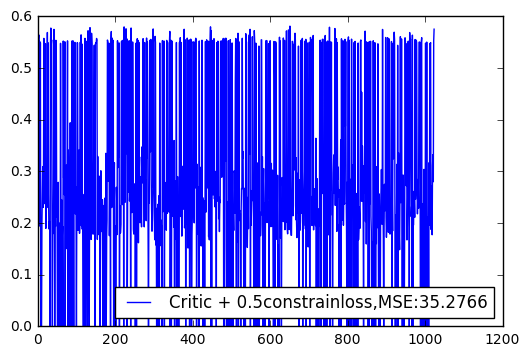

In [961]:
import matplotlib.pyplot as plt
#plt.plot(BBB)
plt.plot(CC[0],label = 'Critic + 0.5constrainloss,MSE:'+ str(np.sum(np.square(CC[0]-0.2960))))
plt.legend(loc='lower right')
plt.show()

In [966]:
(AAA[AAA>0.5].shape[0])/scale_aug/256

0.255859375

In [965]:
(AAA[AAA<0.1].shape[0])/scale_aug/256

0.1591796875

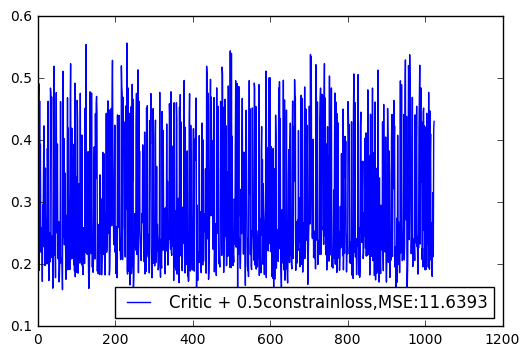

In [952]:
import matplotlib.pyplot as plt
#plt.plot(BBB)
plt.plot(CC_1,label = 'Critic + 0.5constrainloss,MSE:'+ str(np.sum(np.square(CC_1-np.mean(CC)))))
plt.legend(loc='lower right')
plt.show()